In [ ]:
from google.colab import files

uploaded = files.upload()

Saving archive_3.zip to archive_3.zip


In [ ]:
import zipfile
with zipfile.ZipFile('archive_3.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_dir = 'archive_3/seg_train/seg_train'
test_dir = 'archive_3/seg_test/seg_test'
pred_dir = 'archive_3/seg_pred/seg_pred'

In [ ]:
filepaths_train= []
label_train = []
folds = os.listdir(train_dir)
for fold in folds:
    foldpath = os.path.join(train_dir,fold)
    files = os.listdir(foldpath)
    for file in tqdm(files):
        filepath = os.path.join(foldpath,file)
        filepaths_train.append(filepath)
        label_train.append(fold)

100%|██████████| 2274/2274 [00:00<00:00, 598734.92it/s]


In [ ]:
len(filepaths_train)

14034

In [ ]:
dftrain = pd.DataFrame({
'filepaths_train' : filepaths_train,
'label_train' : label_train
})

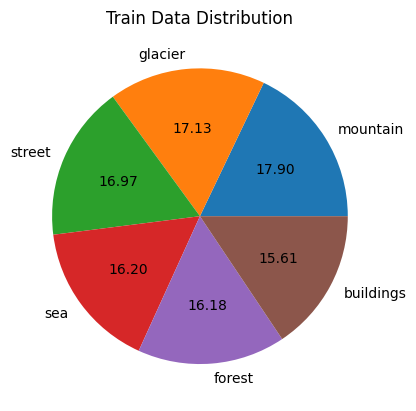

In [ ]:
plt.pie(dftrain['label_train'].value_counts(),labels=dftrain['label_train'].value_counts().index,autopct='%.2f')
plt.title('Train Data Distribution')
plt.show()

In [ ]:
dftrain.head()

,filepaths_train,label_train
0,archive_3/seg_train/seg_train/buildings/4337.jpg,buildings
1,archive_3/seg_train/seg_train/buildings/11620.jpg,buildings
2,archive_3/seg_train/seg_train/buildings/10126.jpg,buildings
3,archive_3/seg_train/seg_train/buildings/8622.jpg,buildings
4,archive_3/seg_train/seg_train/buildings/13603.jpg,buildings


In [ ]:
dftrain['label_train'].value_counts()

,count
label_train,
mountain,2512
glacier,2404
street,2382
sea,2274
forest,2271
buildings,2191


In [ ]:
filepaths_valid = []
label_valid = []
folds = os.listdir(test_dir)
for fold in folds:
    foldpath = os.path.join(test_dir, fold)
    files = os.listdir(foldpath)
    for file in tqdm(files):
        filepath = os.path.join(foldpath, file)
        filepaths_valid.append(filepath)
        label_valid.append(fold)

100%|██████████| 510/510 [00:00<00:00, 470234.13it/s]


In [ ]:
len(filepaths_valid)

3000

In [ ]:
df_valid = pd.DataFrame({
    'filepaths_valid': filepaths_valid,
    'label_valid': label_valid
})

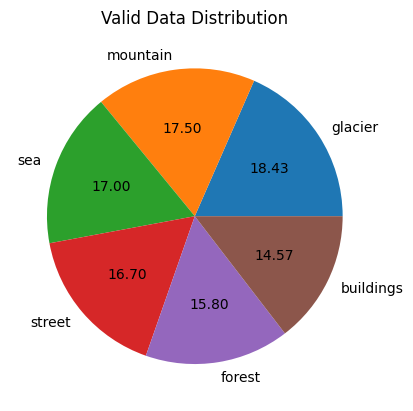

In [ ]:
plt.pie(df_valid['label_valid'].value_counts(),labels=df_valid['label_valid'].value_counts().index,autopct='%.2f')
plt.title('Valid Data Distribution')
plt.show()

In [ ]:
df_valid.head()

,filepaths_valid,label_valid
0,archive_3/seg_test/seg_test/buildings/22025.jpg,buildings
1,archive_3/seg_test/seg_test/buildings/22702.jpg,buildings
2,archive_3/seg_test/seg_test/buildings/21516.jpg,buildings
3,archive_3/seg_test/seg_test/buildings/21221.jpg,buildings
4,archive_3/seg_test/seg_test/buildings/22410.jpg,buildings


In [ ]:
df_valid['label_valid'].value_counts()

,count
label_valid,
glacier,553
mountain,525
sea,510
street,501
forest,474
buildings,437


In [ ]:
filepaths_test = [os.path.join(pred_dir, f) for f in os.listdir(pred_dir) if os.path.isfile(os.path.join(pred_dir, f))]
df_test = pd.DataFrame({
    'filepaths_test': filepaths_test
})

In [ ]:
len(filepaths_test)

7301

# Modeling

# hyperparameters for model training

In [ ]:
IMAGE_SIZE = (224,224)

# image data generator for training and testing data

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_gen = train_datagen.flow_from_dataframe(
    dftrain,
    x_col='filepaths_train',
    y_col='label_train',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    shuffle=True,
    batch_size=32
)

valid_gen = valid_datagen.flow_from_dataframe(
    df_valid,
    x_col='filepaths_valid',
    y_col='label_valid',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    shuffle=False,
    batch_size=32
)

test_gen = test_datagen.flow_from_dataframe(
    df_test,
    x_col='filepaths_test',
    y_col=None,
    target_size=IMAGE_SIZE,
    class_mode=None,
    shuffle=False,
    batch_size=32
)

Found 14034 validated image filenames belonging to 6 classes.
Found 3000 validated image filenames belonging to 6 classes.
Found 7301 validated image filenames.


In [ ]:
classdict = train_gen.class_indices
classdict

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

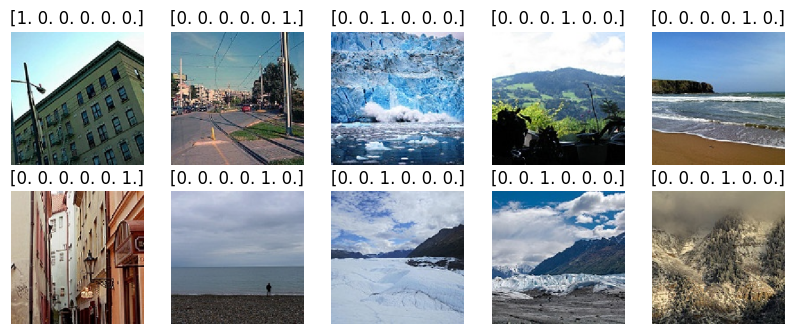

In [ ]:
for batch_image, batch_label in train_gen:
    plt.figure(figsize=(10,10))
    for i in range (10):
        plt.subplot(5,5,i+1)
        plt.imshow(batch_image[i])
        plt.title(batch_label[i])
        plt.axis('off')
    break

# Load the pre-trained VGG16 model

In [ ]:
from tensorflow import keras
base_Model_VGG16  = keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    pooling='max',
    input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3),
)

In [ ]:
ModelPretrainedVGG16= Sequential([
    base_Model_VGG16,

    Dense(256 , activation='relu'),
    Dense(256 , activation='relu'),
    Dense(256 , activation='relu'),
    Dense(6, activation='softmax')

])
ModelPretrainedVGG16.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1,
    mode='min'
)

In [ ]:
ModelPretrainedVGG16_history = ModelPretrainedVGG16.fit(
    train_gen,
    epochs=50,
    validation_data=valid_gen,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 248s 475ms/step - accuracy: 0.4480 - loss: 1.3480 - val_accuracy: 0.7260 - val_loss: 0.7172
Epoch 2/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 206s 468ms/step - accuracy: 0.7756 - loss: 0.6001 - val_accuracy: 0.8107 - val_loss: 0.5239
Epoch 3/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 206s 469ms/step - accuracy: 0.8366 - loss: 0.4486 - val_accuracy: 0.8207 - val_loss: 0.4853
Epoch 4/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 206s 469ms/step - accuracy: 0.8695 - loss: 0.3709 - val_accuracy: 0.8667 - val_loss: 0.3987
Epoch 5/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 212s 482ms/step - accuracy: 0.8922 - loss: 0.3177 - val_accuracy: 0.8853 - val_loss: 0.3291
Epoch 6/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 206s 469ms/step - accuracy: 0.9028 - loss: 0.2758 - val_accuracy: 0.8863 - val_loss: 0.3387
Epoch 7/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 212s 482ms/step - accuracy: 0.9071 - loss: 0.2647 - val_accuracy: 0.8547 - val_loss: 0.4212
Epoch 8/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 206s 468ms/step - accuracy: 0.9156 -

In [ ]:
ModelPretrainedVGG16.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 512)                 │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,937,428 (171.42 MB)

 Trainable params: 14,979,142 (57.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,958,286 (114.28 MB)

In [ ]:
initial_weights = ModelPretrainedVGG16.get_weights()

In [ ]:
ModelPretrainedVGG16.set_weights(initial_weights)

In [ ]:
ModelPretrainedVGG16.save_weights('Image_Detection_Model.weights.h5')

In [ ]:
ModelPretrainedVGG16.save('Image_Detection_Model.h5')

In [ ]:
preds = ModelPretrainedVGG16.predict(valid_gen)
y_pred = np.argmax(preds, axis=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 171ms/step


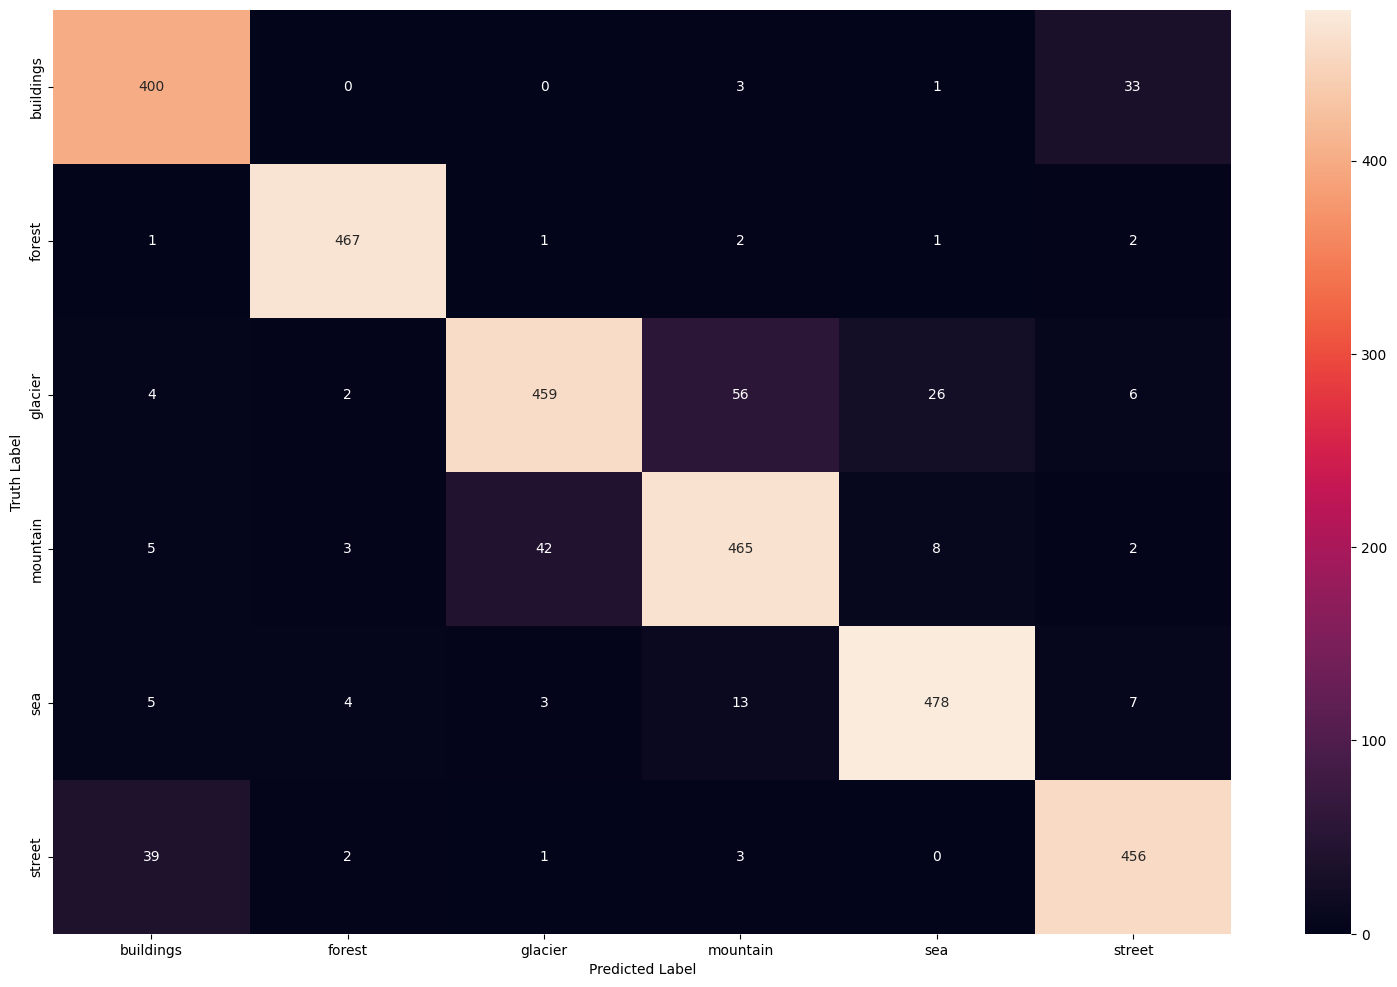

In [ ]:
cm = confusion_matrix(valid_gen.classes, y_pred)
labels = list(classdict.keys())
plt.figure(figsize=(19,12))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

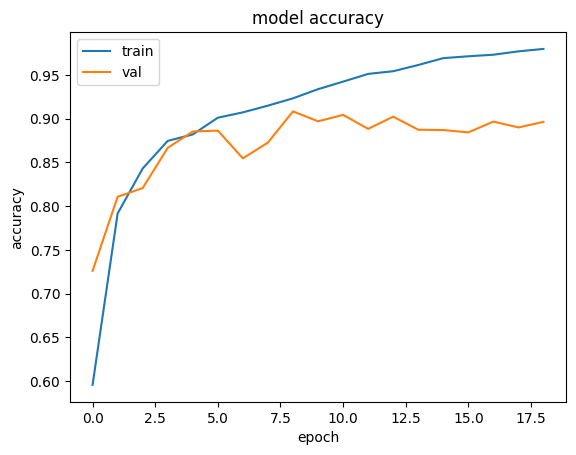

In [ ]:
plt.plot(ModelPretrainedVGG16_history.history['accuracy'])
plt.plot(ModelPretrainedVGG16_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

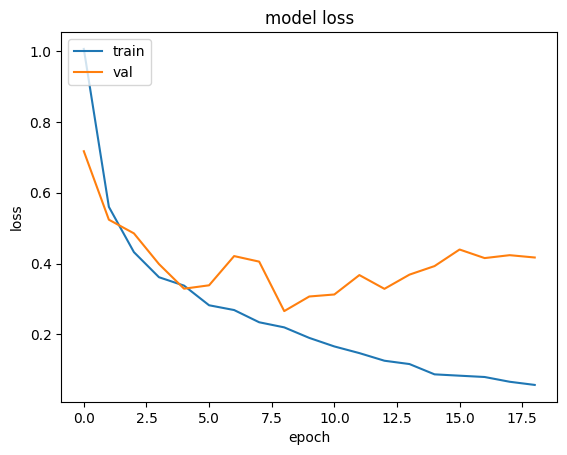

In [ ]:
plt.plot(ModelPretrainedVGG16_history.history['loss'])
plt.plot(ModelPretrainedVGG16_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
from PIL import Image

In [ ]:
def predict(img_path):

    label = list(classdict.keys())
    plt.figure(figsize=(12, 19))
    img = Image.open(img_path)
    resized_img = img.resize((224, 224))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = ModelPretrainedVGG16.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


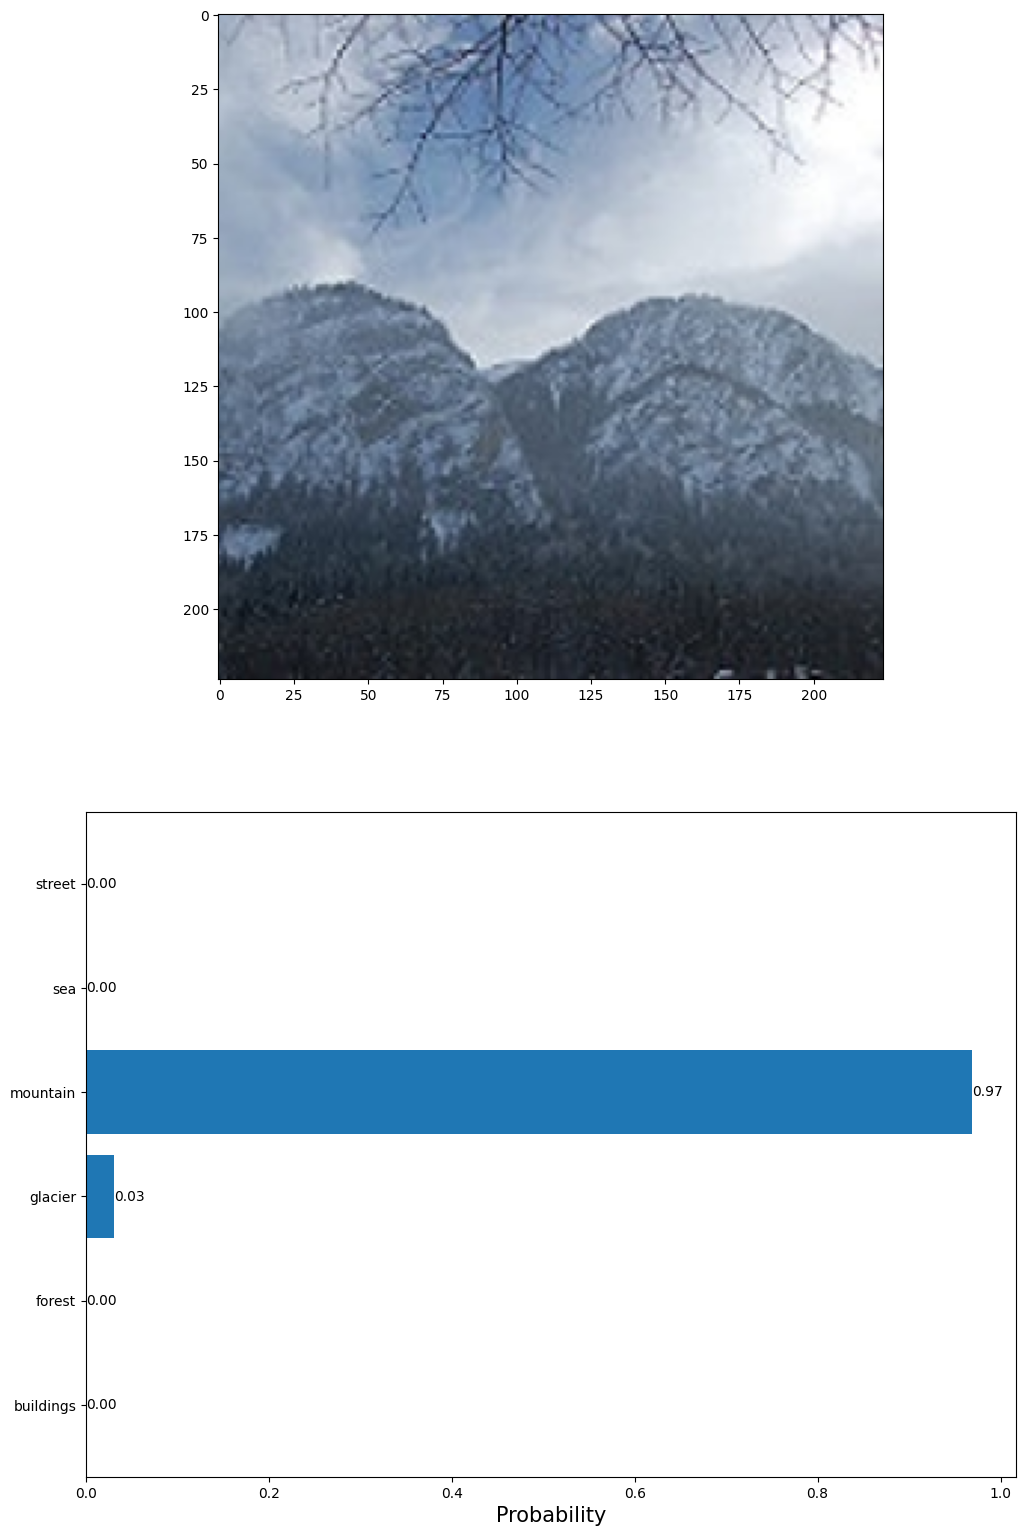

In [ ]:
predict('archive_3/seg_pred/seg_pred/10013.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


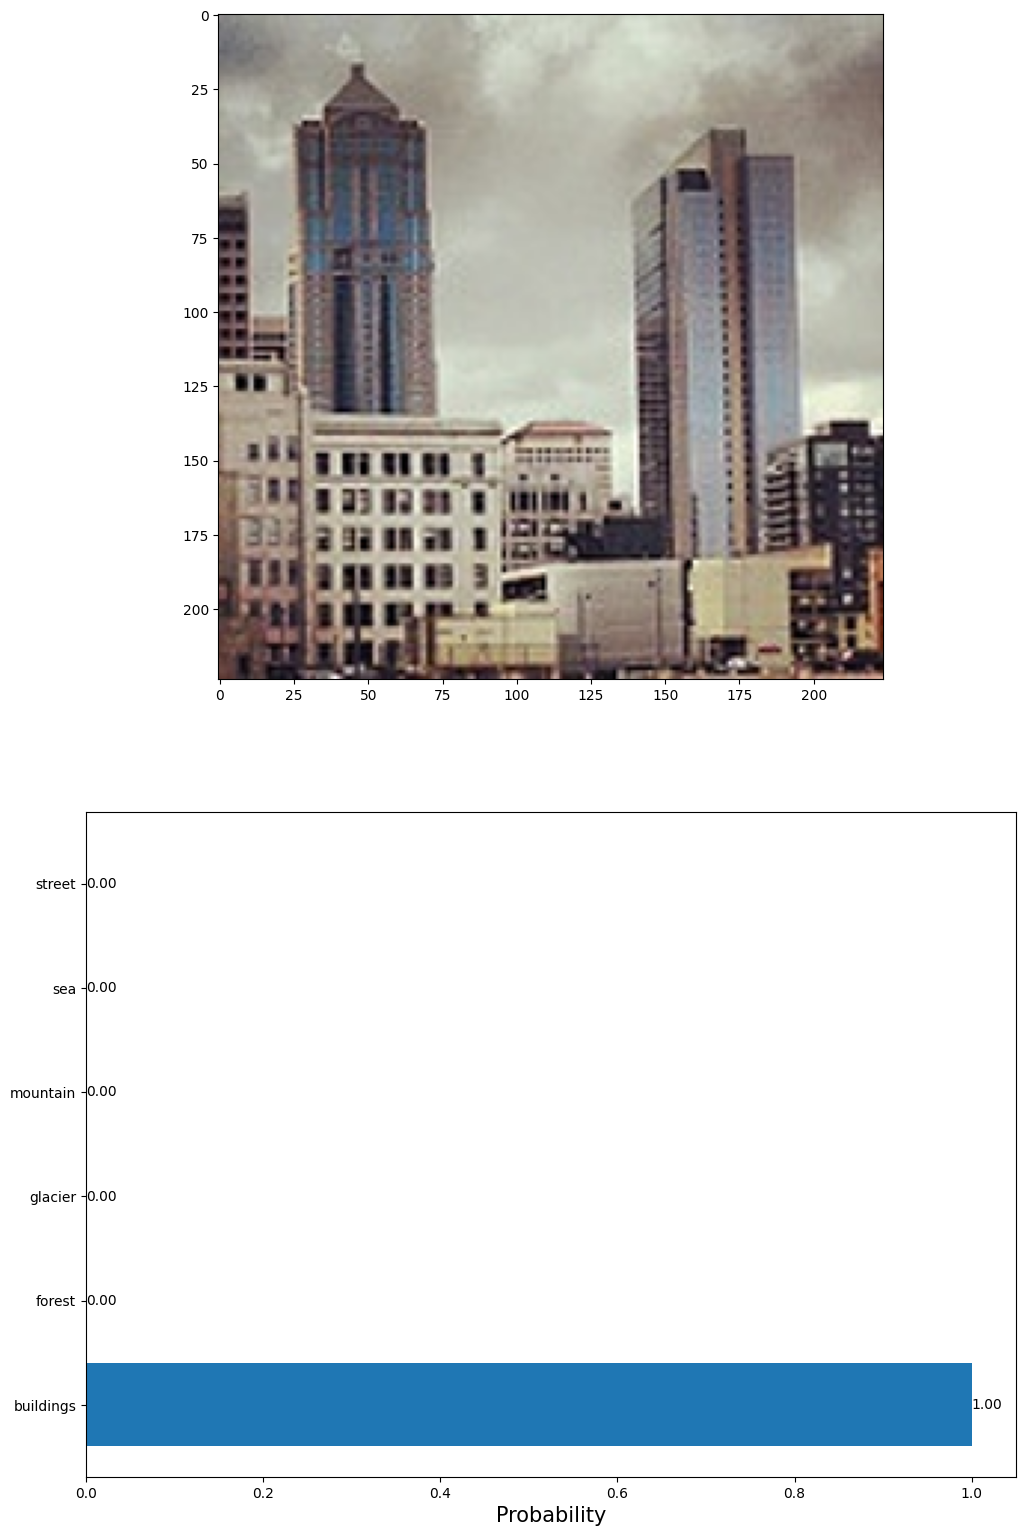

In [ ]:
predict('archive_3/seg_pred/seg_pred/10052.jpg')